# **Avalanche Risk Project**

Advanced Data Analytics, Fall 2025

The following project examines the feasibility of deep learning models (3D-CNN, convLSTM) compared to traditional, state-of-the-art methods for predicting avalanche danger levels. Using a comprehensive dataset from the Swiss Federal Institute for Snow and Avalanche Research (SLF) spanning from 1997-2020, the project heavily relies on the work of Pérez-Guillén et al. (2022) and Maissen et al. (2024) and adopts many of their preprocessing and modeling techniques.

## **3. Baseline Models**

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### **3.1 Data Splitting**

In [30]:
imis_df = pd.read_csv("../data/imis_df_final_clean.csv")

In [31]:
imis_df.columns

Index(['datum', 'station_code', 'sector_id', 'warnreg', 'elevation_station',
       'forecast_initial_date', 'forecast_end_date', 'dangerLevel',
       'elevation_th', 'set', 'Qs', 'Ql', 'Qg0', 'Qr', 'OLWR', 'ILWR',
       'LWR_net', 'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'ISWR_h', 'ISWR_diff',
       'ISWR_dir', 'TA', 'TSS_mod', 'RH', 'VW', 'VW_drift', 'DW', 'MS_Snow',
       'HS_mod', 'HS_meas', 'hoar_size', 'wind_trans24', 'wind_trans24_7d',
       'wind_trans24_3d', 'HN24', 'HN72_24', 'HN24_7d', 'SWE', 'MS_water',
       'MS_Wind', 'MS_Rain', 'MS_SN_Runoff', 'MS_Sublimation', 'MS_Evap',
       'Sclass2', 'zSd_mean', 'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS4', 'S4',
       'zS5', 'ssi_pwl', 'sk38_pwl', 'sn38_pwl', 'ccl_pwl', 'ssi_pwl_100',
       'sk38_pwl_100', 'sn38_pwl_100', 'ccl_pwl_100', 'Pen_depth',
       'min_ccl_pen', 'lon', 'lat', 'delta_elevation', 'month', 'year',
       'delta_TA_24h', 'days_since_last_storm', 'faceting_risk_days_14',
       'relative_load_3d'],
      dtype='objec

In [32]:
imis_df['datum'] = pd.to_datetime(imis_df['datum'], format='%Y-%m-%d')

In [33]:
# Remove non-predictive features
features_to_drop = ['sector_id', 'warnreg', 'forecast_initial_date', 'forecast_end_date',
                   'year', 'lon', 'lat']
imis_df = imis_df.drop(columns=features_to_drop)

In [34]:
imis_df_sorted = imis_df.sort_values(['station_code', 'datum']).copy()

In [35]:
# Split into train and test sets
train_df = imis_df_sorted[imis_df_sorted['set'] == 'train'].drop(columns=['set'])
test_df = imis_df_sorted[imis_df_sorted['set'] == 'test'].drop(columns=['set'])

### **3.2 Naive Model**

In [37]:
# Naive Persistence Model
# Create lagged danger level on the sorted dataframe
imis_df_sorted['dangerLevel_prev'] = imis_df_sorted.groupby('station_code')['dangerLevel'].shift(1)

# NOW filter for test set (after creating the lagged column)
test_naive = imis_df_sorted[imis_df_sorted['set'] == 'test'].dropna(subset=['dangerLevel_prev'])

# Extract true labels and predictions
y_true_naive = test_naive['dangerLevel']
y_pred_naive = test_naive['dangerLevel_prev']

# Calculate metrics
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report

print("📊 Naive Persistence Baseline (Test Set):")
print(f"  Samples evaluated: {len(y_true_naive):,}")
print(f"  Accuracy:          {accuracy_score(y_true_naive, y_pred_naive)*100:.2f}%")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_true_naive, y_pred_naive)*100:.2f}%")
print(f"  F1-Score (Macro):  {f1_score(y_true_naive, y_pred_naive, average='macro'):.3f}")
print(f"  F1-Score (Weighted): {f1_score(y_true_naive, y_pred_naive, average='weighted'):.3f}")

print("\n📋 Per-Class Performance:")
print(classification_report(y_true_naive, y_pred_naive, 
                           target_names=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
                           digits=3))

📊 Naive Persistence Baseline (Test Set):
  Samples evaluated: 34,191
  Accuracy:          76.30%
  Balanced Accuracy: 66.49%
  F1-Score (Macro):  0.665
  F1-Score (Weighted): 0.763

📋 Per-Class Performance:
              precision    recall  f1-score   support

        DL 1      0.883     0.882     0.883     10052
        DL 2      0.738     0.739     0.739     12865
        DL 3      0.712     0.711     0.711     10469
      DL 4/5      0.325     0.327     0.326       805

    accuracy                          0.763     34191
   macro avg      0.665     0.665     0.665     34191
weighted avg      0.763     0.763     0.763     34191



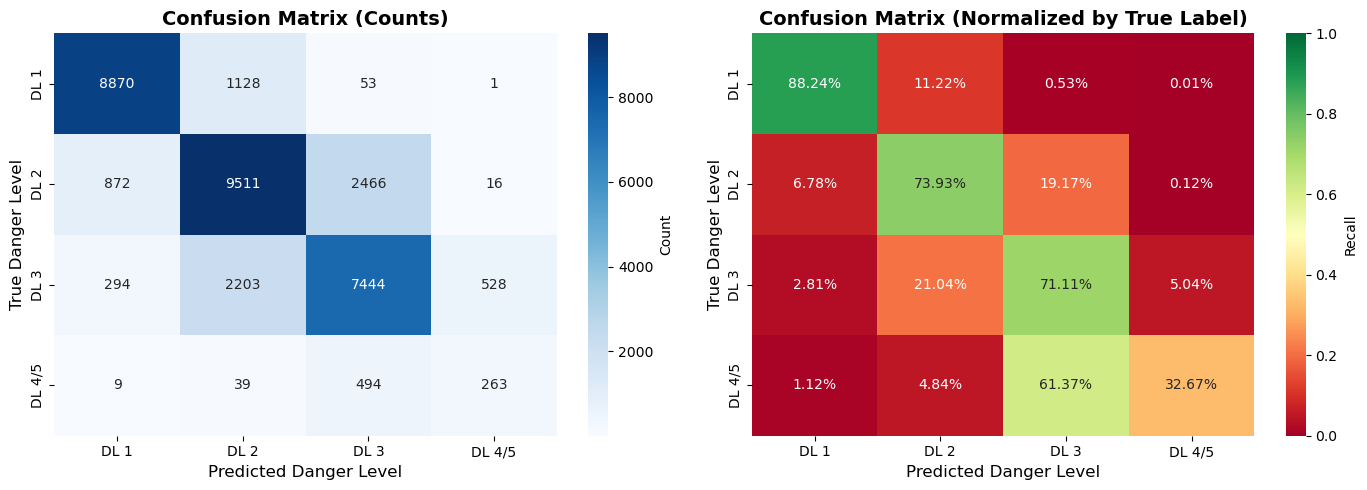


🔍 Key Insights:
  Diagonal sum (correct predictions): 26,088 / 34,191 (76.3%)
  Most confused pair: DL (np.int64(1), np.int64(2))
  DL 1 recall: 88.2%
  DL 2 recall: 73.9%
  DL 3 recall: 71.1%
  DL 4 recall: 32.7%


In [38]:
# Confusion Matrix Visualization
import seaborn as sns

# Create confusion matrix
cm = confusion_matrix(y_true_naive, y_pred_naive)

# Normalize by true labels (row-wise) to show recall per class
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            yticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Danger Level', fontsize=12)
axes[0].set_ylabel('True Danger Level', fontsize=12)

# Plot 2: Normalized (recall)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            yticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            cbar_kws={'label': 'Recall'},
            vmin=0, vmax=1,
            ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized by True Label)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Danger Level', fontsize=12)
axes[1].set_ylabel('True Danger Level', fontsize=12)

plt.tight_layout()
plt.show()

# Print key insights
print("\n🔍 Key Insights:")
print(f"  Diagonal sum (correct predictions): {np.trace(cm):,} / {cm.sum():,} ({np.trace(cm)/cm.sum()*100:.1f}%)")
print(f"  Most confused pair: DL {np.unravel_index(np.argmax(cm - np.diag(np.diag(cm))), cm.shape)}")

# Calculate per-class recall
recalls = np.diag(cm) / cm.sum(axis=1)
for i, recall in enumerate(recalls):
    print(f"  DL {i+1} recall: {recall*100:.1f}%")

C:\Users\fabio\AppData\Local\Temp\ipykernel_18756\621230695.py:21: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\fabio\miniconda3\envs\avalanche_project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


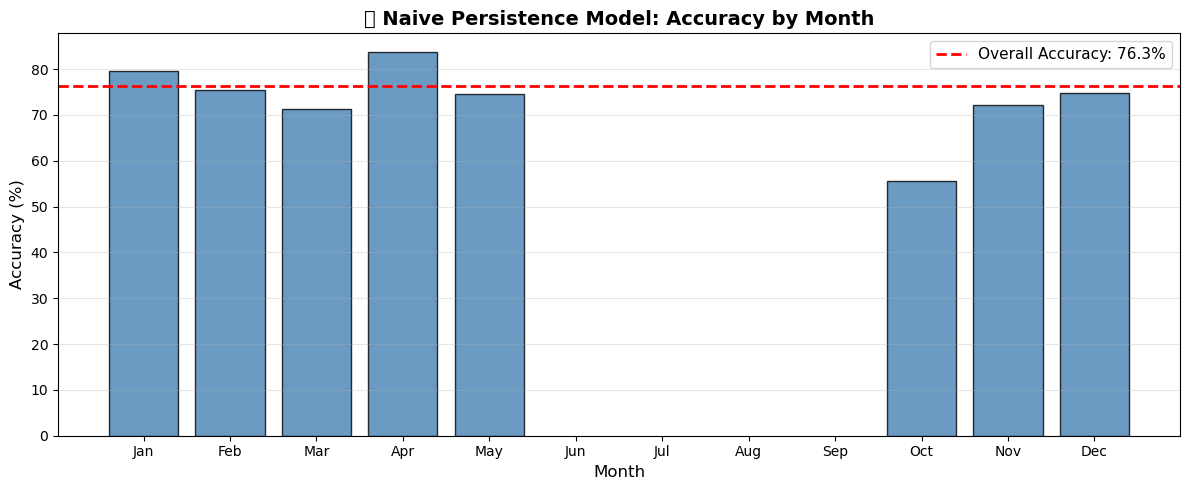


📊 Monthly Performance Summary:
       Accuracy (%)
month              
1              79.6
2              75.4
3              71.3
4              83.6
5              74.7
10             55.6
11             72.2
12             74.7


In [39]:
# Temporal Analysis: Accuracy by Month
test_naive['month'] = test_naive['datum'].dt.month
test_naive['year'] = test_naive['datum'].dt.year
test_naive['correct'] = (test_naive['dangerLevel'] == test_naive['dangerLevel_prev']).astype(int)

# Monthly accuracy
monthly_acc = test_naive.groupby('month')['correct'].mean() * 100

# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(monthly_acc.index, monthly_acc.values, color='steelblue', alpha=0.8, edgecolor='black')
ax.axhline(y=accuracy_score(y_true_naive, y_pred_naive)*100, 
           color='red', linestyle='--', linewidth=2, label=f'Overall Accuracy: {accuracy_score(y_true_naive, y_pred_naive)*100:.1f}%')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('📅 Naive Persistence Model: Accuracy by Month', fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Monthly Performance Summary:")
print(monthly_acc.to_frame('Accuracy (%)').round(1))

### **3.3 Random Forest Model**

In [40]:
train_df.columns

Index(['datum', 'station_code', 'elevation_station', 'dangerLevel',
       'elevation_th', 'Qs', 'Ql', 'Qg0', 'Qr', 'OLWR', 'ILWR', 'LWR_net',
       'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'ISWR_h', 'ISWR_diff', 'ISWR_dir',
       'TA', 'TSS_mod', 'RH', 'VW', 'VW_drift', 'DW', 'MS_Snow', 'HS_mod',
       'HS_meas', 'hoar_size', 'wind_trans24', 'wind_trans24_7d',
       'wind_trans24_3d', 'HN24', 'HN72_24', 'HN24_7d', 'SWE', 'MS_water',
       'MS_Wind', 'MS_Rain', 'MS_SN_Runoff', 'MS_Sublimation', 'MS_Evap',
       'Sclass2', 'zSd_mean', 'Sd', 'zSn', 'Sn', 'zSs', 'Ss', 'zS4', 'S4',
       'zS5', 'ssi_pwl', 'sk38_pwl', 'sn38_pwl', 'ccl_pwl', 'ssi_pwl_100',
       'sk38_pwl_100', 'sn38_pwl_100', 'ccl_pwl_100', 'Pen_depth',
       'min_ccl_pen', 'delta_elevation', 'month', 'delta_TA_24h',
       'days_since_last_storm', 'faceting_risk_days_14', 'relative_load_3d'],
      dtype='object')

In [47]:
trainRF_df = train_df.drop(columns=['datum', 'station_code'], errors='ignore')
testRF_df = test_df.drop(columns=['datum', 'station_code'], errors='ignore')

In [50]:
# Create feature matrices
X_train = trainRF_df.drop(columns=['dangerLevel'])
y_train = trainRF_df['dangerLevel']

X_test = testRF_df.drop(columns=['dangerLevel'])
y_test = testRF_df['dangerLevel']

# Verify
print("✅ Data Preparation Complete:")
print(f"  Training samples: {len(X_train):,} rows × {X_train.shape[1]} features")
print(f"  Test samples: {len(X_test):,} rows × {X_test.shape[1]} features")
print(f"\n📊 Features kept: {list(X_train.columns[:15])}... (showing first 15)")
print(f"\n📊 Target distribution (train):")
print(y_train.value_counts().sort_index())
print(f"\n📊 Target distribution (test):")
print(y_test.value_counts().sort_index())

# Check for missing values
print(f"\n🔍 Missing values in X_train: {X_train.isna().sum().sum()}")
print(f"🔍 Missing values in X_test: {X_test.isna().sum().sum()}")

# Verify no leakage
assert 'dangerLevel' not in X_train.columns, "❌ ERROR: Target leaked into features!"
assert 'datum' not in X_train.columns, "❌ ERROR: Date leaked into features!"
print("\n✅ No data leakage detected!")

✅ Data Preparation Complete:
  Training samples: 257,467 rows × 65 features
  Test samples: 34,197 rows × 65 features

📊 Features kept: ['elevation_station', 'elevation_th', 'Qs', 'Ql', 'Qg0', 'Qr', 'OLWR', 'ILWR', 'LWR_net', 'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'ISWR_h', 'ISWR_diff']... (showing first 15)

📊 Target distribution (train):
dangerLevel
1.0     51527
2.0    107628
3.0     93947
4.0      4365
Name: count, dtype: int64

📊 Target distribution (test):
dangerLevel
1.0    10053
2.0    12868
3.0    10470
4.0      806
Name: count, dtype: int64

🔍 Missing values in X_train: 123
🔍 Missing values in X_test: 6

✅ No data leakage detected!


In [51]:
# Train baseline RF with default parameters
print("🌲 Training Baseline Random Forest...")
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_baseline.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_baseline.predict(X_test)

# Evaluate
print("\n📊 Random Forest Baseline Performance (Test Set):")
print(f"  Accuracy:          {accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_rf)*100:.2f}%")
print(f"  F1-Score (Macro):  {f1_score(y_test, y_pred_rf, average='macro'):.3f}")
print(f"  F1-Score (Weighted): {f1_score(y_test, y_pred_rf, average='weighted'):.3f}")

print("\n📋 Per-Class Performance:")
print(classification_report(y_test, y_pred_rf, 
                           target_names=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
                           digits=3))

🌲 Training Baseline Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   45.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s



📊 Random Forest Baseline Performance (Test Set):
  Accuracy:          83.69%
  Balanced Accuracy: 67.27%
  F1-Score (Macro):  0.687
  F1-Score (Weighted): 0.831

📋 Per-Class Performance:
              precision    recall  f1-score   support

        DL 1      0.994     0.999     0.997     10053
        DL 2      0.817     0.805     0.811     12868
        DL 3      0.719     0.776     0.746     10470
      DL 4/5      0.781     0.110     0.193       806

    accuracy                          0.837     34197
   macro avg      0.828     0.673     0.687     34197
weighted avg      0.838     0.837     0.831     34197



[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


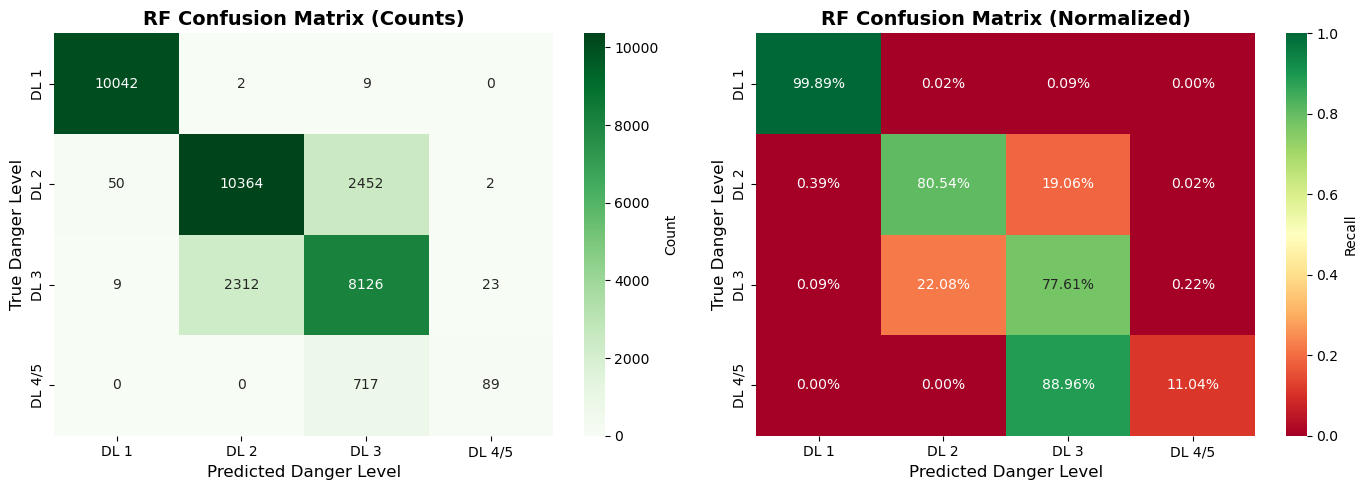


🔍 Key Insights:
  Diagonal sum (correct predictions): 28,621 / 34,197 (83.7%)
  DL 1 recall: 99.9%
  DL 2 recall: 80.5%
  DL 3 recall: 77.6%
  DL 4 recall: 11.0%


In [52]:
# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_normalized = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Raw counts
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            yticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            cbar_kws={'label': 'Count'},
            ax=axes[0])
axes[0].set_title('RF Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Danger Level', fontsize=12)
axes[0].set_ylabel('True Danger Level', fontsize=12)

# Plot 2: Normalized (recall)
sns.heatmap(cm_rf_normalized, annot=True, fmt='.2%', cmap='RdYlGn', 
            xticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            yticklabels=['DL 1', 'DL 2', 'DL 3', 'DL 4/5'],
            cbar_kws={'label': 'Recall'},
            vmin=0, vmax=1,
            ax=axes[1])
axes[1].set_title('RF Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Danger Level', fontsize=12)
axes[1].set_ylabel('True Danger Level', fontsize=12)

plt.tight_layout()
plt.show()

# Print key insights
print("\n🔍 Key Insights:")
print(f"  Diagonal sum (correct predictions): {np.trace(cm_rf):,} / {cm_rf.sum():,} ({np.trace(cm_rf)/cm_rf.sum()*100:.1f}%)")

# Calculate per-class recall
recalls_rf = np.diag(cm_rf) / cm_rf.sum(axis=1)
for i, recall in enumerate(recalls_rf):
    print(f"  DL {i+1} recall: {recall*100:.1f}%")

C:\Users\fabio\AppData\Local\Temp\ipykernel_18756\2686625017.py:17: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\fabio\miniconda3\envs\avalanche_project\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


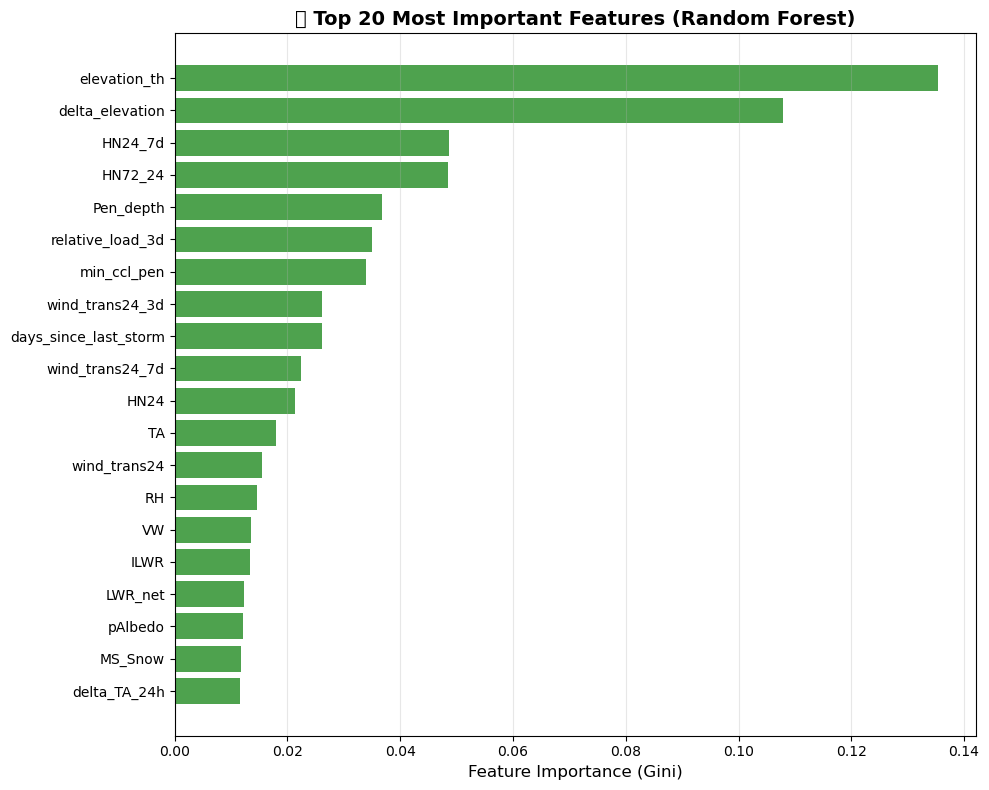


📊 Top 10 Most Important Features:
              feature  importance
         elevation_th    0.135423
      delta_elevation    0.107925
              HN24_7d    0.048728
              HN72_24    0.048470
            Pen_depth    0.036706
     relative_load_3d    0.035029
          min_ccl_pen    0.033845
      wind_trans24_3d    0.026198
days_since_last_storm    0.026108
      wind_trans24_7d    0.022362


In [53]:
# Extract feature importances
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_20 = feature_importance.head(20)
ax.barh(range(len(top_20)), top_20['importance'], color='forestgreen', alpha=0.8)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance (Gini)', fontsize=12)
ax.set_title('🌲 Top 20 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Print top 10
print("\n📊 Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [200, 500], 
    'max_depth': [10, 20, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4], 
    'max_features': ['sqrt']
}

# Use TimeSeriesSplit for temporal validation
tscv = TimeSeriesSplit(n_splits=3)

# Grid search
print("🔍 Starting GridSearchCV (this may take 10-20 minutes)...")
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=tscv,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Best parameters
print("\n✅ Best Hyperparameters:")
print(grid_search.best_params_)

# Retrain with best params
rf_tuned = grid_search.best_estimator_
y_pred_tuned = rf_tuned.predict(X_test)

print("\n📊 Tuned Random Forest Performance:")
print(f"  Accuracy:          {accuracy_score(y_test, y_pred_tuned)*100:.2f}%")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_tuned)*100:.2f}%")
print(f"  F1-Score (Macro):  {f1_score(y_test, y_pred_tuned, average='macro'):.3f}")

🔍 Starting GridSearchCV (this may take 10-20 minutes)...
Fitting 3 folds for each of 54 candidates, totalling 162 fits
